In [2]:
import pandas as pd
import csv
import numpy as np
from scipy import ndimage
from numpy import asarray
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pyabf
from datetime import timedelta
import cv2
import os
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from neo.io import AxonIO
from matplotlib.gridspec import GridSpec
import urllib
import neo

In [3]:
def DataFrameNameToString(df):
    # Get the variable name of the DataFrame as a string
    for name, var in globals().items():
        if var is df:
            return name

In [4]:
def ABFreader(filelocation): # this function will transform ABF files into dataframes
    # Open the ABF file using AxonIO from the neo package
    fh = AxonIO(filename=filelocation)
    
    # Read the segments from the file
    segments = fh.read_block().segments
    
    # Extract the analog signals from the first segment
    analog_signals_ls = segments[0].analogsignals
    
    # Create an empty DataFrame to store the ABF data
    df = pd.DataFrame()
    
    # Create an empty list to store the time values
    list=[]
    
    # Initialize a time counter
    tc=0
    
    # Read a single segment from the file
    seg = fh.read_segment()
    
    # Loop to populate the time list
    while tc < len(seg.analogsignals[0]):
        list.append(tc)
        tc=tc+1
        
    # Create a DataFrame from the time list
    df = pd.DataFrame (list, columns = ['trash'])
    
    # Add columns to the DataFrame using the analog signals
    df['Vm_prime'] = analog_signals_ls[0]
    df['Im_sec'] = analog_signals_ls[1]
    
    # Split the third analog signal into two channels
    channel_splitter=np.split(analog_signals_ls[2], 3, axis=1) #if you added more channels to clampex zou have to change it here 
    
    # Add the two channels to the DataFrame as separate columns
    df['led'] =  channel_splitter[0][:]
    df['Photodiod'] =  channel_splitter[1][:]
    df['Arduino'] =  channel_splitter[2][:]
    
    # Drop the 'trash' column from the DataFrame
    df=df.drop(columns=["trash"])
    return df

# File paths

In [5]:
file_path_1=r"D:\230919_firstRecordingsinFlight\5attempt\rec2\2023_09_19_0005.abf"
file_path_2=r"D:\230923_Patch\2ndPrep\1strecording\2023_09_22_0000.abf"
file_path_3=r"D:\230923_Patch\3rprep\2ndattempt\2ndrecording\2023_09_22_0003.abf"
file_path_4=r"D:\231011_Patch\311\2023_10_11_0000.abf"

In [6]:
filepath = [file_path_1, file_path_2, file_path_3, file_path_4]

In [7]:
df_abf_1=ABFreader(file_path_1)
df_abf_2=ABFreader(file_path_2)


In [8]:
df_abf_3=ABFreader(file_path_3)

In [9]:
def ABFreader(filelocation): # this function will transform ABF files into dataframes
    # Open the ABF file using AxonIO from the neo package
    fh = AxonIO(filename=filelocation)
    
    # Read the segments from the file
    segments = fh.read_block().segments
    
    # Extract the analog signals from the first segment
    analog_signals_ls = segments[0].analogsignals
    
    # Create an empty DataFrame to store the ABF data
    df = pd.DataFrame()
    
    # Create an empty list to store the time values
    list=[]
    
    # Initialize a time counter
    tc=0
    
    # Read a single segment from the file
    seg = fh.read_segment()
    
    # Loop to populate the time list
    while tc < len(seg.analogsignals[0]):
        list.append(tc)
        tc=tc+1
        
    # Create a DataFrame from the time list
    df = pd.DataFrame (list, columns = ['trash'])
    
    # Add columns to the DataFrame using the analog signals
    df['Vm_prime'] = analog_signals_ls[0]
    df['Im_sec'] = analog_signals_ls[1]
    df['Photodiod'] = analog_signals_ls[3]
    
    # Split the third analog signal into two channels
    channel_splitter=np.split(analog_signals_ls[2], 4, axis=1) #if you added more channels to clampex zou have to change it here 
    
    # Add the two channels to the DataFrame as separate columns
    df['Trigger'] =  channel_splitter[0][:]
    df['AirPuff'] =  channel_splitter[1][:]
    df['TrigWings '] =  channel_splitter[2][:]
    df['TrigEyes'] =  channel_splitter[3][:]
    

    
    
    # Drop the 'trash' column from the DataFrame
    df=df.drop(columns=["trash"])
    return df

In [10]:
df_abf_4=ABFreader(file_path_4)

# Add a time column

In [11]:
dataframes = [df_abf_1, df_abf_2, df_abf_3, df_abf_4]

In [12]:
def add_time_abf(df, sampling_rate=10000.0):
    time_seconds = pd.Series(range(len(df_abf_1))) / sampling_rate
    time_milliseconds = time_seconds * 1000.0
    df['time_sec'] = time_seconds
    df['time_millisec'] = time_milliseconds
    

In [13]:
for df in dataframes:
    add_time_abf(df)



# Substract junction potential

In [14]:
def SubstractJunctionPotential(df):
    df['Vm_corrected']=df['Vm_prime'] - 13

In [15]:
for df in dataframes:
    SubstractJunctionPotential(df)

# Find threshold for ABF files

In [16]:
def find_first_frame_abf(df, column_name, x_axis_name = 'time_millisec' , adjustment=0, threshold_multiplier=6) :
    median_intensity = np.nanmedian(df[column_name])
    q1 = np.nanpercentile(df[column_name], 25)
    q3 = np.nanpercentile(df[column_name], 75)
    iqr_value = q3 - q1
    thresh_intensity = median_intensity - threshold_multiplier * iqr_value
    thresh_intensity = thresh_intensity-adjustment  # for noisy recordings

    plt.plot(df[column_name])
    plt.axhline(y=thresh_intensity, color='r')
    plt.show()

    first_frame_number = np.where(df[column_name] < thresh_intensity)[0][0]

    plt.plot(df[column_name][first_frame_number - 2:first_frame_number + 2])
    plt.axhline(y=thresh_intensity, color='r')
    plt.show()

    return first_frame_number

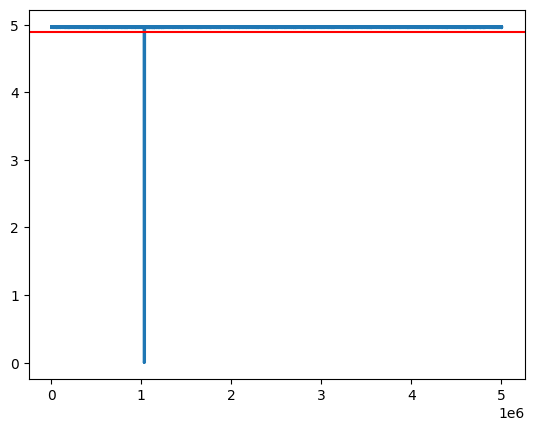

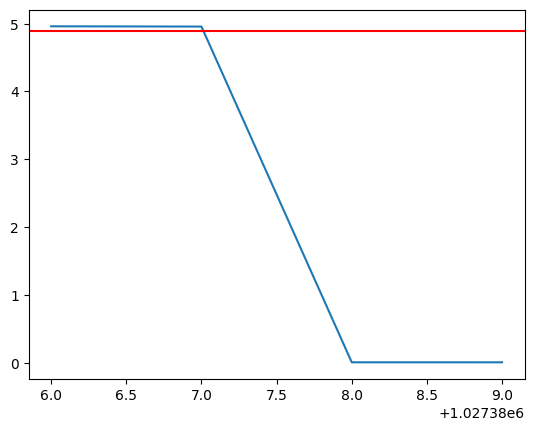

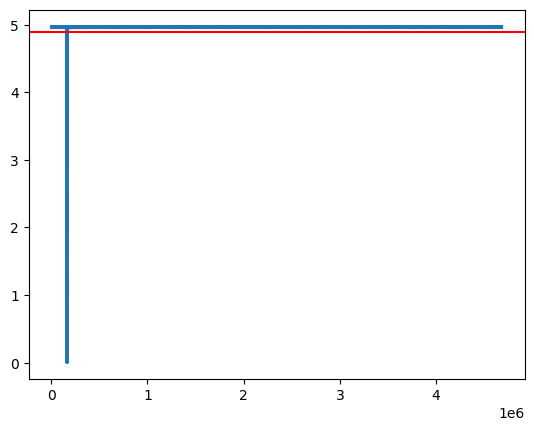

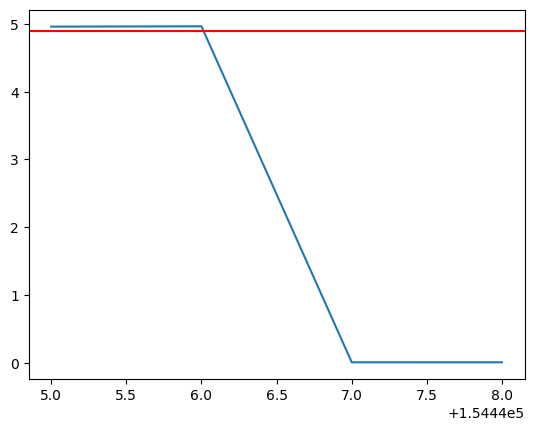

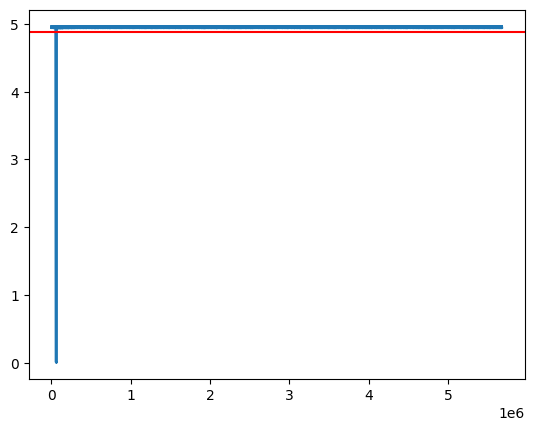

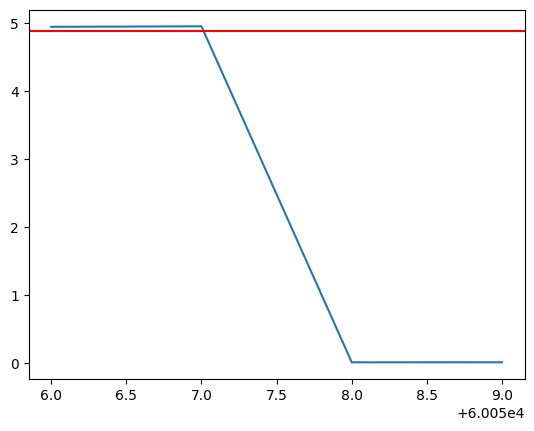

In [17]:
first_frame_df_abf_1=find_first_frame_abf(df_abf_1,'led',threshold_multiplier=8)
first_frame_df_abf_3=find_first_frame_abf(df_abf_3,'led',threshold_multiplier=8)
first_frame_df_abf_4=find_first_frame_abf(df_abf_4,'Trigger',threshold_multiplier=8)

In [18]:
df_abf_1['time_milliseconds_zero'] = (df_abf_1.index - first_frame_df_abf_1) / 10  # Assuming 10 Hz sampling rate, adjust as needed
df_abf_3['time_milliseconds_zero'] = (df_abf_3.index - first_frame_df_abf_3) / 10  # Assuming 10 Hz sampling rate, adjust as needed
df_abf_4['time_milliseconds_zero'] = (df_abf_4.index - first_frame_df_abf_4) / 10  # Assuming 10 Hz sampling rate, adjust as needed

# save df at .csv

In [19]:
def save_dataframe_to_csv(dataframe, file_path):
    dataframe.to_csv(file_path, index=False)



In [20]:
save_dataframe_to_csv(df_abf_1, r'D:\230919_firstRecordingsinFlight\5attempt\rec2\df_abf_1.csv')
save_dataframe_to_csv(df_abf_2, r'D:\230923_Patch\2ndPrep\1strecording\df_abf_2.csv')
save_dataframe_to_csv(df_abf_3, r'D:\230923_Patch\3rprep\2ndattempt\2ndrecording\df_abf_3.csv')
save_dataframe_to_csv(df_abf_4, r'D:\231011_Patch\311\df_abf_4.csv')


In [21]:
df_abf_1

,Vm_prime,Im_sec,led,Photodiod,Arduino,time_sec,time_millisec,Vm_corrected,time_milliseconds_zero
0,-40.838623,-7.324218,4.966431,-0.058289,-0.211487,0.0000,0.0,-53.838623,-102738.8
1,-40.899658,-7.934570,4.956055,-0.057678,-0.211182,0.0001,0.1,-53.899658,-102738.7
2,-40.942383,-7.934570,4.956665,-0.057373,-0.212097,0.0002,0.2,-53.942383,-102738.6
3,-41.003418,-7.934570,4.967651,-0.057678,-0.212402,0.0003,0.3,-54.003418,-102738.5
4,-41.027832,-8.544922,4.960022,-0.057983,-0.211182,0.0004,0.4,-54.027832,-102738.4
...,...,...,...,...,...,...,...,...,...
5007355,-38.745117,-7.934570,4.966736,-0.057678,-0.212097,500.7355,500735.5,-51.745117,397996.7
5007356,-38.739014,-7.324218,4.963684,-0.057373,-0.212097,500.7356,500735.6,-51.739014,397996.8
5007357,-38.751221,-6.713867,4.952393,-0.057373,-0.213013,500.7357,500735.7,-51.751221,397996.9
5007358,-38.775635,-7.934570,4.961853,-0.057678,-0.212097,500.7358,500735.8,-51.775635,397997.0


In [23]:
print(first_frame_df_abf_1, first_frame_df_abf_3, first_frame_df_abf_4)

1027388 154447 60058
